 compilations of figures for 4th WIP talk. These figures might be found in other scripts or jupyter notebooks

In [1]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler

import src.data.LDA as cLDA
import src.data.dPCA as cdPCA
import src.metrics.dprime as cDP
import src.visualization.fancy_plots as fplt
from src.data.load import load
from src.data.cache import set_name
from src.visualization.fancy_plots import savefig
from src.metrics.reliability import signal_reliability

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-11-04 184105.log


In [2]:
#general plottin formating

plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [2]:
# path to caches and meta parameters
config = ConfigParser()
config.read_file(open(pl.Path().cwd().parent / 'config' / 'settings.ini'))

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': ['silence', 'continuous', 'similar', 'sharp'],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

In [20]:
# loads the summary metrics
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'DF_summary' / set_name(meta)

DF = jl.load(summary_DF_file)

# create the id_probe pair for
DF['id_probe'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id_probe', 'probe']].agg('_'.join, axis=1)


In [4]:
# load digested data

rec_recache = False
all_probes = [2, 3, 5, 6]


# load the calculated dprimes and montecarlo shuffling/simulations
# the loadede dictionary has 3 layers, analysis, value type and cell/site
batch_dprimes_file = pl.Path(config['paths']['analysis_cache']) / 'batch_dprimes' / set_name(meta)
batch_dprimes = jl.load(batch_dprimes_file)

sites = set(batch_dprimes['dPCA']['dprime'].keys())
all_cells = set(batch_dprimes['SC']['dprime'].keys())

In [5]:
# some small preprocecing of the digested data.
# defines a significant threshold and transform the pvalues into boolean (significant vs nonsignificant)
threshold = 0.01
for analysis_name, mid_dict in batch_dprimes.items():
    mid_dict['shuffled_significance'] = {key: (val <= threshold) for key, val in mid_dict['shuffled_pvalue'].items()}
    if analysis_name != 'SC':
        mid_dict['simulated_significance'] = {key: (val <= threshold) for key, val in
                                             mid_dict['simulated_pvalue'].items()}

# set up the time bin labels in milliseconds, this is critical for plotting and calculating the tau
nbin = np.max([value.shape[-1] for value in batch_dprimes['SC']['dprime'].values()])
fs = meta['raster_fs']
times = np.linspace(0, nbin / fs, nbin, endpoint=False) * 1000

bar_width = 1 / fs * 1000
fig_root = 'single_cell_context_dprime'


# plots related to steps in data procesing and examples

In [17]:
# functions taken/modified from 200221_exp_fit_SC_dPCA_LDA_examples.py

def analysis_steps_plot(id, probe, source):
    site = id[:7] if source == 'SC' else id

    # loads the raw data
    recs = load(site, rasterfs=meta['raster_fs'], recache=False)
    sig = recs['trip0']['resp']
    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()
    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = cdPCA.raster_from_sig(sig, probe, channels=goodcells, transitions=meta['transitions'],
                                   smooth_window=meta['smoothing_window'], raster_fs=meta['raster_fs'],
                                   zscore=meta['zscore'], part='probe')
    # trialR shape: Trial x Cell x Context x Probe x Time; R shape: Cell x Context x Probe x Time
    trialR, R, _ = cdPCA.format_raster(raster)
    trialR, R = trialR.squeeze(axis=3), R.squeeze(axis=2)  # squeezes out probe

    if source == 'dPCA':
        projection, _ = cdPCA.fit_transform(R, trialR)
    elif source == 'LDA':
        projection, _ = cLDA.fit_transform_over_time(trialR)
        projection = projection.squeeze(axis=1)

    if meta['zscore'] is False:
        trialR = trialR * meta['raster_fs']
        if source == 'dPCA':
            projection = projection * meta['raster_fs']

    # flips signs of dprimes and montecarlos as needed
    dprimes, shuffleds = cDP.flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')
    if source in ['dPCA', 'LDA']:
        _, simulations = cDP.flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['simulated_dprime'][id], flip='max')

    t = times[:trialR.shape[-1]]
    # nrows = 2 if source == 'SC' else 3
    nrows = 2
    fig, axes = plt.subplots(nrows, 6, sharex='all', sharey='row')

    #  PSTH
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        t0_idx = meta['transitions'].index(trans[0])
        t1_idx = meta['transitions'].index(trans[1])

        if source == 'SC':
            cell_idx = goodcells.index(id)
            axes[0, tt].plot(t, trialR[:, cell_idx, t0_idx, :].mean(axis=0), color=trans_color_map[trans[0]],
                             linewidth=3)
            axes[0, tt].plot(t, trialR[:, cell_idx, t1_idx, :].mean(axis=0), color=trans_color_map[trans[1]],
                             linewidth=3)
        else:
            axes[0, tt].plot(t, projection[:, t0_idx, :].mean(axis=0), color=trans_color_map[trans[0]], linewidth=3)
            axes[0, tt].plot(t, projection[:, t1_idx, :].mean(axis=0), color=trans_color_map[trans[1]], linewidth=3)

    # Raster, dprime, CI
    bottom, top = axes[0, 0].get_ylim()
    half = ((top - bottom) / 2) + bottom
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        prb_idx = all_probes.index(probe)
        pair_idx = tt

        if source == 'SC':
            # raster
            cell_idx = goodcells.index(id)
            t0_idx = meta['transitions'].index(trans[0])
            t1_idx = meta['transitions'].index(trans[1])

            _ = fplt._raster(t, trialR[:, cell_idx, t0_idx, :], y_offset=0, y_range=(bottom, half), ax=axes[0, tt],
                             scatter_kws={'color': trans_color_map[trans[0]], 'alpha': 0.4, 's': 10})
            _ = fplt._raster(t, trialR[:, cell_idx, t1_idx, :], y_offset=0, y_range=(half, top), ax=axes[0, tt],
                             scatter_kws={'color': trans_color_map[trans[1]], 'alpha': 0.4, 's': 10})

        # plots the real dprime and the shuffled dprime ci
        axes[1, tt].plot(t, dprimes[prb_idx, pair_idx, :], color='white')
        _ = fplt._cint(t, shuffleds[:, prb_idx, pair_idx, :], confidence=0.95, ax=axes[1, tt],
                       fillkwargs={'color': 'white', 'alpha': 0.5})

        # if source in ['dPCA', 'LDA']:
        #     # plots the real dprime and simulated dprime ci
        #     axes[2, tt].plot(t, dprimes[prb_idx, pair_idx, :], color='white')
        #     _ = fplt._cint(t, simulations[:, prb_idx, pair_idx, :], confidence=0.95, ax=axes[2, tt],
        #                    fillkwargs={'color': 'white', 'alpha': 0.5})

    # significance bars
    ax1_bottom = axes[1, 0].get_ylim()[0]
    # if source == 'dPCA':
    #     ax2_bottom = axes[2, 0].get_ylim()[0]
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        prb_idx = all_probes.index(probe)
        pair_idx = tt
        # histogram of context discrimination
        axes[1, tt].bar(t, batch_dprimes[source]['shuffled_significance'][id][prb_idx, pair_idx, :],
                        width=bar_width, align='center', color='gray', edgecolor='white', bottom=ax1_bottom)
        # if source in ['dPCA', 'LDA']:
        #     # histogram of population effects
        #     axes[2, tt].bar(t, batch_dprimes[source]['simulated_significance'][id][prb_idx, pair_idx, :],
        #                     width=bar_width, align='center', edgecolor='white', bottom=ax2_bottom)

        # formats legend
        if tt == 0:
            if source == 'SC':
                axes[0, tt].set_ylabel(f'z-score')
            elif source == 'dPCA':
                axes[0, tt].set_ylabel(f'dPC')
            axes[1, tt].set_ylabel(f'dprime')
            # if source in ['dPCA', 'LDA']:
            #     axes[2, tt].set_ylabel(f'dprime')

        axes[-1, tt].set_xlabel('time (ms)')
        axes[0, tt].set_title(f'{trans[0][:3]}_{trans[1][:3]}')

        for ax in np.ravel(axes):
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    return fig, axes

def non_param_example_plot(id, probe, trans_pair, source):
    """
    Plots dprime and significant bins. Displays the correspondente significant area under the curve (green) and its
    center of mass (dashed vertical white line)
    :param id: str. cell or site id
    :param source: str. 'SC', 'dPCA', or 'LDA'
    :return: fig, axes.
    """

    # flips signs of dprimes and montecarlos as neede
    dprimes, shuffleds = cDP.flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')
    signif_bars = batch_dprimes[source]['shuffled_significance'][id]

    probe_idx = all_probes.index(probe)
    trans_pair_idx = trans_pair

    mean_dprime = dprimes[probe_idx, trans_pair_idx, :]
    mean_signif = signif_bars[probe_idx, trans_pair_idx, :]
    signif_mask = mean_signif>0

    t = times[:dprimes.shape[-1]]
    # calculates center of mass and integral
    significant_abs_mass_center = np.sum(np.abs(mean_dprime[signif_mask]) * t[signif_mask]) / np.sum(np.abs(mean_dprime[signif_mask]))
    significant_abs_sum = np.sum(np.abs(mean_dprime[signif_mask])) * np.mean(np.diff(t))

    # fig, axes = plt.subplots(2, 1, sharex='all', sharey='all')
    fig, axes = plt.subplots()

    # plots dprime plus fit
    axes.plot(t, mean_dprime, color='white')
    axes.axhline(0, color='gray', linestyle='--')
    axes.fill_between(t, mean_dprime, 0, where=signif_mask, color='green', label=f"integral\n{significant_abs_sum:.2f} ms*d'")
    # _ = fplt.exp_decay(t, mean_dprime, ax=axes[0], linestyle='--', color='white')

    # plots confifence bins plut fit

    # ax1_bottom = axes.get_ylim()[0]
    ax1_bottom = -1
    axes.bar(t, mean_signif*0.5, width=bar_width, align='center',
                color='gray', edgecolor='white', bottom= ax1_bottom, alpha=0.8)
    # _ = fplt.exp_decay(times, mean_signif, ax=axes[1], linestyle='--', color='white')


    axes.axvline(significant_abs_mass_center, color='white', linewidth=3, linestyle='--',
                 label=f'center of mass\n{significant_abs_mass_center:.2f} ms')

    axes.legend()
    # axes[1].legend()

    # formats axis, legend and so on.

    axes.set_ylabel(f'dprime')
    axes.set_xlabel('time (ms)')

    return fig, axes

def category_summary_plot(id, source):
    """
    Plots calculated dprime, confidense interval of shuffled dprime, and histogram of significant bins, for all contexts
    and probes.
    Subplots are a grid of al combinations of probe (rows) and context pairs (columns), plus the means of each category,
    and the grand mean
    :param id: str. cell or site id
    :param source: str. 'SC', 'dPCA', or 'LDA'
    :return: fig, axes.
    """

    # flips signs of dprimes and montecarlos as neede
    dprimes, shuffleds = cDP.flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')
    signif_bars = batch_dprimes[source]['shuffled_significance'][id]

    t = times[:dprimes.shape[-1]]
    fig, axes = plt.subplots(5, 7, sharex='all', sharey='all')

    # dprime and confidence interval for each probe-transition combinations
    for (pp, probe), (tt, trans) in itt.product(enumerate(all_probes),
                                                enumerate(itt.combinations(meta['transitions'], 2))):
        prb_idx = all_probes.index(probe)

        # plots the real dprime and the shuffled dprime
        axes[pp, tt].plot(t, dprimes[prb_idx, tt, :], color='white')
        _ = fplt._cint(t, shuffleds[:, prb_idx, tt, :], confidence=0.95, ax=axes[pp, tt],
                       fillkwargs={'color': 'white', 'alpha': 0.5})
    # dprime and ci for the mean across context pairs
    for pp, probe in enumerate(all_probes):
        prb_idx = all_probes.index(probe)
        axes[pp, -1].plot(t, np.mean(dprimes[prb_idx, :, :], axis=0), color='white')
        axes[pp, -1].axhline(0, color='gray', linestyle='--')

    # dprime and ci for the mean across probes
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        axes[-1, tt].plot(t, np.mean(dprimes[:, tt, :], axis=0), color='white')
        axes[-1, tt].axhline(0, color='gray', linestyle='--')

    # significance bars for each probe-transition combinations
    bar_bottom = axes[0, 0].get_ylim()[0]
    for (pp, probe), (tt, trans) in itt.product(enumerate(all_probes),
                                                enumerate(itt.combinations(meta['transitions'], 2))):
        prb_idx = all_probes.index(probe)
        axes[pp, tt].bar(t, signif_bars[prb_idx, tt, :], width=bar_width, align='center', color='gray',
                         edgecolor='white', bottom=bar_bottom)
        # _ = fplt.exp_decay(t, signif_bars[prb_idx, tt, :], ax=axes[2, tt])

    # significance bars for the mean across context pairs
    for pp, probe in enumerate(all_probes):
        prb_idx = all_probes.index(probe)
        axes[pp, -1].bar(t, np.mean(signif_bars[prb_idx, :, :], axis=0), width=bar_width, align='center', color='gray',
                         edgecolor='white', bottom=bar_bottom)
        # _ = fplt.exp_decay(t, np.mean(signif_bars[prb_idx, :, :], axis=0), ax=axes[pp, -1], yoffset=bar_bottom,
        #                    linestyle=':', color='gray')
        # axes[pp, -1].legend(loc='upper right', fontsize='small', markerscale=3, frameon=False)

    # significance bars for the mean across probes
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        axes[-1, tt].bar(t, np.mean(signif_bars[:, tt, :], axis=0), width=bar_width, align='center', color='gray',
                         edgecolor='white', bottom=bar_bottom)
        # _ = fplt.exp_decay(t, np.mean(signif_bars[:, tt, :], axis=0), axes[-1, tt], yoffset=bar_bottom,
        #                    linestyle=':', color='gray')
        # axes[-1, tt].legend(loc='upper right', fontsize='small', markerscale=3, frameon=False)

    # cell summary mean: dprime, confidence interval
    axes[-1, -1].plot(t, np.mean(dprimes[:, :, :], axis=(0, 1)), color='white')
    axes[-1, -1].axhline(0, color='gray', linestyle='--')
    axes[-1, -1].bar(t, np.mean(signif_bars[:, :, :], axis=(0, 1)), width=bar_width, align='center', color='gray',
                     edgecolor='white', bottom=bar_bottom)
    # _ = fplt.exp_decay(t, np.mean(signif_bars[:, :, :], axis=(0, 1)), ax=axes[-1, -1], yoffset=bar_bottom,
    #                    linestyle=':', color='gray')
    # axes[-1, -1].legend(loc='upper right', fontsize='small', markerscale=3, frameon=False)

    # formats axis, legend and so on.
    for pp, probe in enumerate(all_probes):
        axes[pp, 0].set_ylabel(f'probe {probe}')
    axes[-1, 0].set_ylabel(f'probe\nmean')

    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        axes[0, tt].set_title(f'{trans[0][:3]}_{trans[1][:3]}')
        axes[-1, tt].set_xlabel('time (ms)')
    axes[0, -1].set_title(f'pair\nmean')
    axes[-1, -1].set_xlabel('time (ms)')

    for ax in np.ravel(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    return fig, axes

def site_cell_summary(id):
    """
    plots a grid of subplots, each one showing the real dprime, histogram of significant bins and fitted exponential
    decay to the significant bins. Both the dprime and significant bins are the cell grand mean across probes and
    context pairs
    :param id: str. site id
    :return: fig, axes
    """

    site_cells = set([cell for cell in batch_dprimes['SC']['dprime'].keys() if cell[:7] == id])

    fig, axes = fplt.subplots_sqr(len(site_cells), sharex=True, sharey=True)
    for ax, cell in zip(axes, site_cells):
        grand_mean, _ = cDP.flip_dprimes(batch_dprimes['SC']['dprime'][cell], flip='max')
        line = np.mean(grand_mean, axis=(0, 1))
        hist = np.mean(batch_dprimes['SC']['shuffled_significance'][cell], axis=(0, 1))
        ax.plot(times[:len(line)], line, color='white')
        ax.axhline(0, color='gray', linestyle='--' )
        ax.bar(times[:len(hist)], hist, width=bar_width, align='center', color='gray', edgecolor='white',bottom=-0.5)
        # _ = fplt.exp_decay(times[:len(hist)], hist, ax=ax, linestyle='--', color='gray')
        # ax.set_title(cell)
        # ax.legend(loc='upper right', fontsize='small', markerscale=3)

    return fig, axes

def dPCA_site_summary(site, probe):
    # loads the raw data
    recs = load(site, rasterfs=meta['raster_fs'], recache=rec_recache)
    sig = recs['trip0']['resp']

    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = cdPCA.raster_from_sig(sig, probe, channels=goodcells, transitions=meta['transitions'],
                                   smooth_window=meta['smoothing_window'], raster_fs=meta['raster_fs'],
                                   zscore=meta['zscore'], part='probe')

    # trialR shape: Trial x Cell x Context x Probe x Time; R shape: Cell x Context x Probe x Time
    trialR, R, _ = cdPCA.format_raster(raster)
    trialR, R = trialR.squeeze(axis=3), R.squeeze(axis=2)  # squeezes out probe
    Z, trialZ, dpca = cdPCA._cpp_dPCA(R, trialR)

    fig, axes = plt.subplots(1, 3, sharex='all', sharey='row', squeeze=True)
    # for vv, (marginalization, arr) in enumerate(Z.items()):
    marginalization = 'ct'

    means = Z[marginalization]
    trials = trialZ[marginalization]

    if marginalization == 't':
        marginalization = 'probe'
    elif marginalization == 'ct':
        marginalization = 'context'
    for pc in range(3):  # first 3 principal components

        ax = axes[pc]
        for tt, trans in enumerate(meta['transitions']):  # for each context
            ax.plot(times, means[pc, tt, :], label=trans, color=trans_color_map[trans], linewidth=2)
            # _ = fplt._cint(times, trials[:,pc,tt,:],  confidence=0.95, ax=ax,
            #                fillkwargs={'color': trans_color_map[trans], 'alpha': 0.5})

        # formats axes labels and ticks
        if pc == 0 :
            ax.set_ylabel(f'{marginalization} dependent\nfiring rate (z-score)')
        ax.set_title(f'dPC #{pc + 1}')
        ax.set_xlabel('time (ms)')

    # legend in last axis
    # axes[-1, -1].legend(fontsize='x-large', markerscale=10,)
    axes[-1].legend(fontsize='x-large', markerscale=10,)

    return fig, ax, dpca

In [9]:
# finds the unit-probe combination and site with the highes absolute integral and hopefully center of mass

ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_trans = DF.transition_pair != 'mean'
ff_probe = DF.probe != 'mean'

# single cell
ff_analysis = DF.analysis=='SC'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['cellid', 'probe'], columns='parameter', values='value')
single_cell_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(5)

# population
ff_analysis = DF.analysis=='dPCA'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['siteid', 'probe'], columns='parameter', values='value')
population_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(5)

print(single_cell_top)
print(population_top)

In [7]:
# # old example sites
# ['AMT028b', 'DRX008b']
# # old example units
# ['AMT028b-20-1', 'DRX008b-04-1']
# # old example probe
# probe = 2

# one of the short experiments
# cell = 'DRX021a-10-2'
# site = 'DRX021a'
# probe = 2

cell = 'AMT029a-51-1'
site = 'AMT029a'
probe = 5

## analysis steps

loading recording from box
SC, AMT029a-51-1 probe 5 calc steps
loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.025511577864105985
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please               

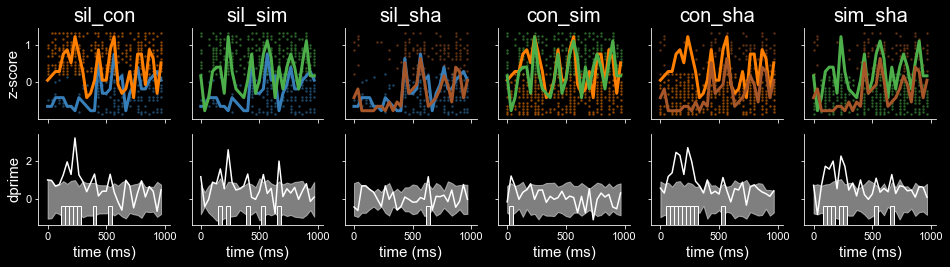

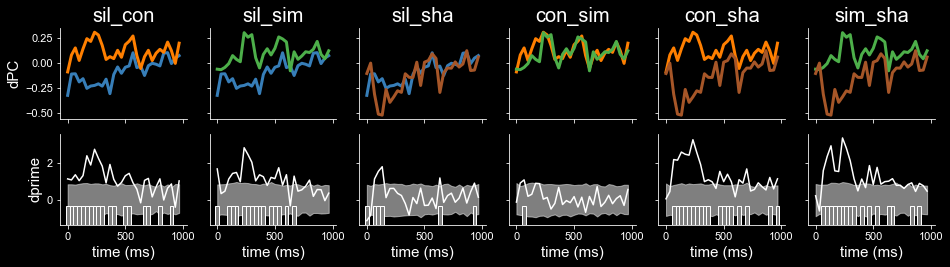

In [135]:
# SC examples
fig, axes = analysis_steps_plot(cell, probe, 'SC')
fig.set_size_inches(13.3, 3.81)
title = f'SC, {cell} probe {probe} calc steps'
print(title)
savefig(fig, 'WIP4_figures', title, type='png')
plt.show()

# dPCA examples
fig, axes = analysis_steps_plot(site, probe, 'dPCA')
fig.set_size_inches(13.3, 3.81)
title = f'dPCA, {site} probe {probe}, calc steps'
print(title)
savefig(fig, 'WIP4_figures', title, type='png')
plt.show()

## example fit, to be modified for area under the curve

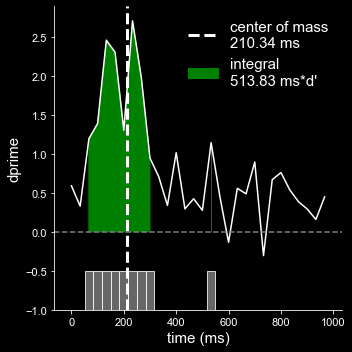

In [122]:
# SC examples
fig, axes = non_param_example_plot(cell, probe, 4, 'SC')
title = f'SC, {cell} probe_{probe} param calc summary'
fig.set_size_inches([5,5])
fplt.savefig(fig, 'WIP4_figures', title)
plt.show()

# # dPCA site examples
# fig, axes = fit_example_plot(site, probe, 4, 'dPCA')
# title = f'dPCA, {site} fit summary'
# # fplt.savefig(fig, 'WIP4_figures', title)
# plt.show()

## all categorie of transition pairs and probes

SC, AMT029a-51-1 probe context_pair summary


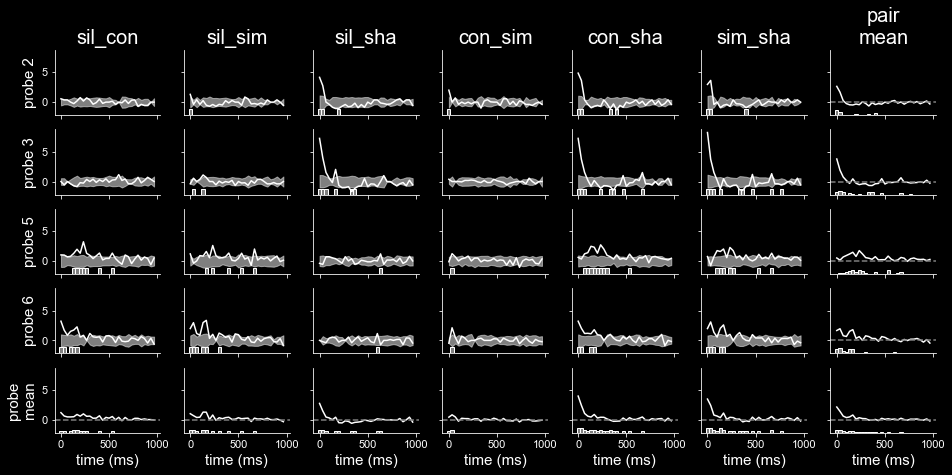

In [136]:
# SC example
fig, axes = category_summary_plot(cell, 'SC')
# fig.set_size_inches(np.asarray([16, 9])*0.7)
fig.set_size_inches(np.asarray([13.33, 6.7]))
title = f'SC, {cell} probe context_pair summary'
print(title)
# fig.suptitle(title)
savefig(fig, 'WIP4_figures', title)
plt.show()

# # dpca site example
# fig, axes = category_summary_plot(site, 'dPCA')
# fig.set_size_inches(np.asarray([16, 9])*0.7)
# title = f'dPCA, {site} probe context_pair summary'
# print(title)
# # fig.suptitle(title)
# savefig(fig, 'WIP4_figures', title)
# plt.show()

## summary of all cells in site

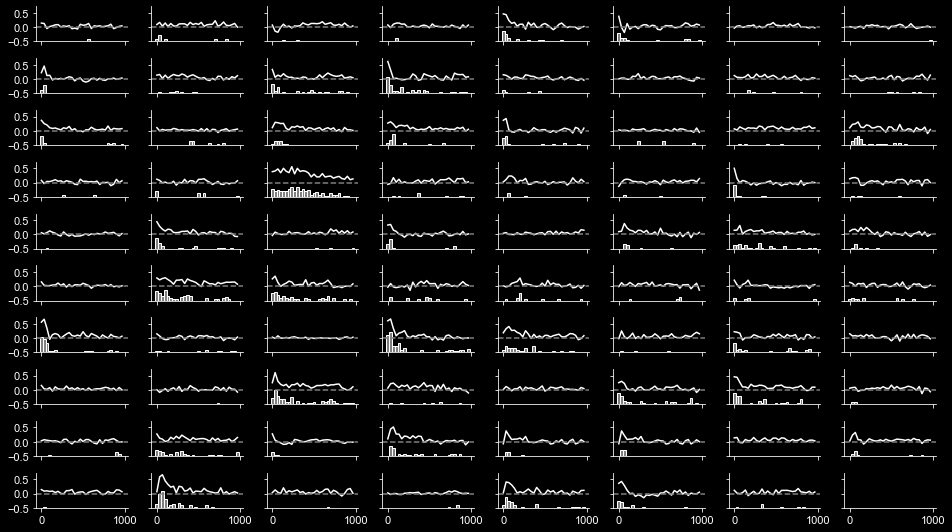

In [146]:
big_site = 'DRX008b'
fig, axes = site_cell_summary(big_site) # site with most cells
fig.set_size_inches(np.asarray([13.33, 7.5]))
title = f'{big_site} all cells summary'
# fig.suptitle(title)
# fig.tight_layout(rect=(0, 0, 1, 0.95))
savefig(fig, 'WIP4_figures', title)
plt.show()

## dPCA projecdtion and variance explained

loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.025511577864105985
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


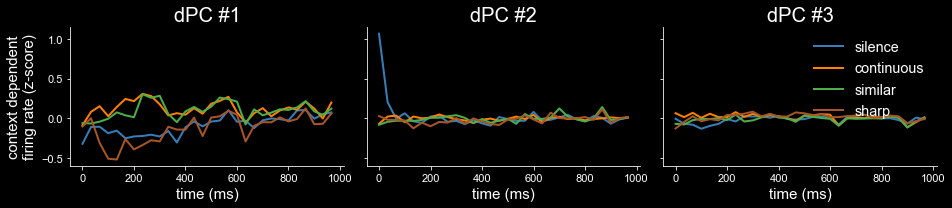

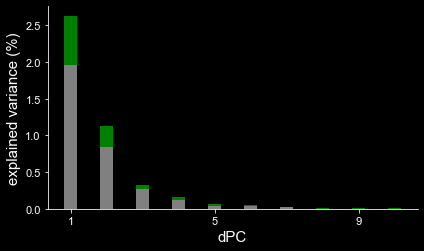

In [18]:
fig1, axes, dpca = dPCA_site_summary(site, probe)
fig1.set_size_inches((13.33, 3))
title = f'{site} probe-{probe} dPCA projection'
# fig1.suptitle(title)
# fig1.tight_layout(rect=(0, 0, 1, 0.95))
savefig(fig1, 'WIP4_figures', title, type='png')
plt.show()


fig2, ax, inset = cdPCA.variance_explained(dpca, ax=None, names=['probe', 'context'], colors=['gray', 'green'],
                                                  inset=False)

fig2.set_size_inches((6, 3.6))
title = f'{site} probe-{probe} dPCA variance explained'
# _, labels, autotexts = inset
# plt.setp(autotexts, size=15, weight='normal')
# plt.setp(labels, size=15, weight='normal')
# var_ax.set_title('marginalized variance')
savefig(fig2, 'WIP4_figures', title, type='png')
plt.show()

# plots related to summary metrics

In [58]:
def parameter_space_scatter(x, y, analysis='SC', source='dprime', ax=None):

    ff_parameter = DF.parameter.isin([x, y])
    ff_analysis = DF.analysis == analysis
    ff_source = DF.source == source
    ff_probe = DF.probe == 'mean'
    ff_transpair= DF.transition_pair == 'mean'
    ff_good = np.logical_or(DF.goodness > 0.1, DF.goodness.isna()) # empirical good value to filter out garbage cells


    filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good, :]
    pivoted = filtered.pivot_table(index=['id_probe', 'region', 'siteid'],
                                   columns='parameter', values='value').dropna().reset_index()

    _, _, r2, _, _ = sst.linregress(pivoted[x], pivoted[y])


    ax = sns.regplot(x=x, y=y, data=pivoted, ax=ax, color='white', label=f'n={len(pivoted.index)}\nr2={r2:.2f}')
    ax.axhline(0, linestyle='--')
    ax.axvline(0, linestyle='--')

    fig = ax.get_figure()
    return fig, ax

def condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pairs', analysis='SC',
                                  source='drpime', nan2zero=False, nozero=True):
    if compare == 'probe':
        ff_probe = DF.probe != 'mean'
        ff_trans = DF.transition_pair == 'mean'
    elif compare == 'transition_pair':
        ff_probe = DF.probe == 'mean'
        ff_trans = DF.transition_pair != 'mean'
    else:
        raise ValueError(f'unknown value compare: {compare}')

    if analysis == 'SC':
        index = 'cellid'
    elif analysis in ('dPCA', 'LDA'):
        index = 'siteid'
    else:
        raise ValueError(f'unknown analysis value:{analysis}')


    ff_analisis = DF.analysis == analysis
    ff_parameter = DF.parameter == parameter
    ff_source = DF.source == source
    if nozero:
        ff_value = DF.value > 0
    elif nozero is False:
        ff_value = DF.value >= 0
    else:
        raise ValueError('nozero not bool')

    filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_value,
                      [index, compare, 'goodness', 'value']]
    pivoted = filtered.pivot(index=index, columns=compare, values='value')
    if nan2zero:
        pivoted = pivoted.fillna(value=0).reset_index()
    elif nan2zero is False:
        pivoted = pivoted.dropna().reset_index()
    else:
        raise ValueError('nan2zero not bool')

    molten = pivoted.melt(id_vars=index, var_name=compare)

    fig, ax = plt.subplots()
    # _ = fplt.paired_comparisons(ax, data=molten,x=compare, y='value', color='gray', alpha=0.3)
    ax = sns.boxplot(x=compare, y='value', data=molten, ax=ax, color='white', width=0.5)

    # no significant comparisons
    box_pairs = list(itt.combinations(filtered[compare].unique(), 2))
    stat_resutls = fplt.add_stat_annotation(ax, data=molten, x=compare, y='value', test='Wilcoxon',
                                       box_pairs=box_pairs, width=0.5, comparisons_correction='bonferroni')

    if parameter == 'significant_abs_sum':
        ylabel = "integral (ms*d')"
        title = f'integral\nn={len(pivoted.index)}'

    elif parameter == 'significant_abs_mass_center':
        ylabel = 'center of mass (ms)'
        title = f'center of mass\nn={len(pivoted.index)}'
    else:
        ylabel = 'value'
    ax.set_ylabel(ylabel)
    ax.set_title(fill(title,35))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    return fig, ax

def condition_effect_on_parameter_cell_probe(parameter='significant_abs_mass_center', analysis='SC', source='dprime',
                                             nan2zero=False, nozero=True):

    ff_probe = DF.probe != 'mean'
    ff_trans = DF.transition_pair != 'mean'

    ff_analisis = DF.analysis == analysis
    ff_parameter = DF.parameter == parameter
    ff_source = DF.source == source
    if nozero:
        ff_value = DF.value > 0
    elif nozero is False:
        ff_value = DF.value >= 0
    else:
        raise ValueError('nozero not bool')

    ff_good = np.logical_or(DF.goodness > 0.1, DF.goodness.isnull())

    filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_value & ff_good, :].copy()

    pivoted = filtered.pivot_table(index='id_probe', columns='transition_pair', values='value')

    if nan2zero:
        pivoted = pivoted.fillna(value=0).reset_index()
    elif nan2zero is False:
        pivoted = pivoted.dropna().reset_index()
    else:
        raise ValueError('nan2zero not bool')

    molten = pivoted.melt(id_vars='id_probe', var_name='transition_pair')

    # _ = fplt.paired_comparisons(ax, data=molten,x=compare, y='value', color='gray', alpha=0.3)
    ax = sns.boxplot(x='transition_pair', y='value', data=molten, color='white', width=0.5)

    # no significant comparisons
    box_pairs = list(itt.combinations(filtered['transition_pair'].unique(), 2))
    stat_resutls = fplt.add_stat_annotation(ax, data=molten, x='transition_pair', y='value', test='Wilcoxon',
                                       box_pairs=box_pairs, width=0.5, comparisons_correction='bonferroni')

    if parameter == 'significant_abs_sum':
        ylabel = "integral (ms*d')"
        title = f'integral\nn={len(pivoted.index)}'

    elif parameter == 'significant_abs_mass_center':
        ylabel = 'center of mass (ms)'
        title = f'center of mass\nn={len(pivoted.index)}'
    else:
        ylabel = 'value'
    ax.set_ylabel(ylabel)
    ax.set_title(fill(title,35))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return fig, ax

def dPCA_SC_param_comparison(parameter, nan2zero=False, nozero=True, id_probe=False):

    if id_probe:
        ff_probe = DF.probe != 'mean'
    else:
        ff_probe = DF.probe == 'mean'
    ff_trans = DF.transition_pair == 'mean'


    ff_param = DF.parameter == parameter
    ff_source = DF.source == 'dprime'

    if nozero:
        ff_value = DF.value > 0
    elif nozero is False:
        ff_value = DF.value >= 0
    else:
        raise ValueError('nozero not bool')

    ff_anal = DF.analysis == 'SC'
    sing = DF.loc[ff_anal & ff_probe & ff_trans & ff_param & ff_source & ff_value,
                  ['id_probe', 'region', 'siteid', 'cellid', 'parameter', 'value']]

    sing['site_probe'] =  DF[['siteid', 'probe']].agg('_'.join, axis=1)

    sing_pivot = sing.pivot(index='site_probe', columns='cellid', values='value')

    if nan2zero:
        sing_pivot = sing_pivot.fillna(0)

    sing_pivot['agg'] = sing_pivot.max(axis=1)

    ff_anal = DF.analysis == 'dPCA'
    pops = DF.loc[ff_anal & ff_probe & ff_trans & ff_param & ff_source & ff_value,
                  ['id_probe', 'region', 'siteid', 'cellid', 'parameter', 'value']]

    if nan2zero:
        pops = pops.fillna(0)

    pops['site_probe'] = DF['id_probe']
    pops = pops.set_index('site_probe')

    toplot = pd.concat((pops.loc[:, ['region', 'value']], sing_pivot.loc[:, 'agg']), axis=1)

    _, _, r2, _, _ = sst.linregress(toplot['value'], toplot['agg'])

    ax = sns.regplot(x='value', y='agg', data=toplot, color='white', label=f'n={len(toplot.index)}\nr2={r2:.2f}')
    sns.despine(ax=ax)
    _ = fplt.unit_line(ax, square_shape=False)

    if parameter == 'significant_abs_mass_center':
        parameter = 'center of mass'
        xlabel = f"population (ms)"
        ylabel = f'single cell max (ms)'
    elif parameter == 'significant_abs_sum':
        parameter = 'integral'
        xlabel = f"population (ms*d')"
        ylabel = f"single cell max (ms*d')"

    else:
        xlabel='value'
        ylabel='value'

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig = ax.figure
    title = f'{parameter}'
    ax.set_title(fill(title, 35))
    plt.show()

    return fig,ax

## parameter space

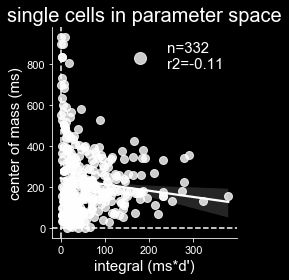

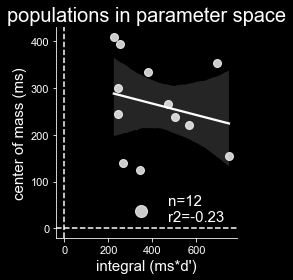

In [34]:
# parameter space
x = 'significant_abs_sum'
y = 'significant_abs_mass_center'

# single cell
analysis = 'SC'
fig, ax = parameter_space_scatter(x, y, analysis=analysis)

title = f'single cells in parameter space'
ax.set_title(fill(title, 35))
ax.set_xlabel("integral (ms*d')")
ax.set_ylabel("center of mass (ms)")
ax.legend(markerscale=1.5)

file = f'{analysis} summary {x} vs {y}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

# population
analysis = 'dPCA'
fig, ax = parameter_space_scatter(x, y, analysis=analysis)
title = f'populations in parameter space '
ax.set_title(fill(title, 35))
ax.set_xlabel("integral (ms*d')")
ax.set_ylabel("center of mass (ms)")
ax.legend(loc='best', markerscale=1.5)

file = f'{analysis} summary {x} vs {y}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

## transition_pair effect

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
continuous_similar v.s. silenc

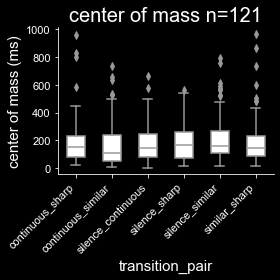

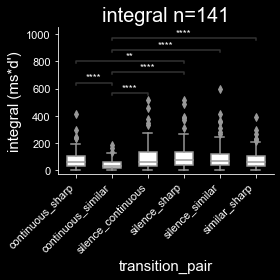

In [44]:
# single cell
analysis = 'SC'
source = 'dprime'
compare='transition_pair'

# center of mass
parameter = 'significant_abs_mass_center'
fig, ax = condition_effect_on_parameter(parameter, compare, analysis, source, nan2zero=False, nozero=True)

file = f'{analysis} {source}-{parameter} between {compare}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

# integral
parameter = 'significant_abs_sum'
fig, ax = condition_effect_on_parameter(parameter, compare, analysis, source, nan2zero=False, nozero=True)

file = f'{analysis} {source}-{parameter} between {compare}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
continuous_sharp v.s. continuous_similar: Wilcoxon test (pair

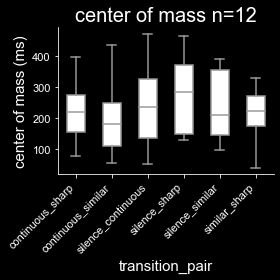

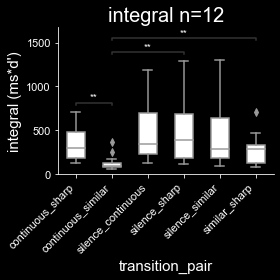

In [45]:
# population
analysis = 'dPCA'
source = 'dprime'
compare='transition_pair'

# center of mass
parameter = 'significant_abs_mass_center'
fig, ax = condition_effect_on_parameter(parameter, compare, analysis, source, nan2zero=False, nozero=True)

file = f'{analysis} {source}-{parameter} between {compare}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

# integral
parameter = 'significant_abs_sum'
fig, ax = condition_effect_on_parameter(parameter, compare, analysis, source, nan2zero=False, nozero=True)

file = f'{analysis} {source}-{parameter} between {compare}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

# population by site-probe

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
continuous_similar v.s. silenc

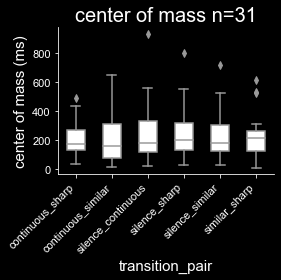

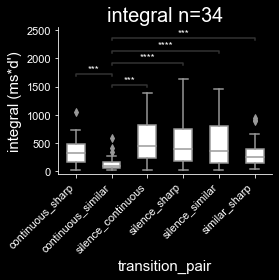

In [48]:
# population
analysis = 'dPCA'
source = 'dprime'
compare='transition_pair'

# center of mass
parameter = 'significant_abs_mass_center'
fig, ax = condition_effect_on_parameter_cell_probe(parameter, analysis, source,
                                                    nan2zero=False, nozero=True)
file = f'{analysis} id_probe {source}-{parameter} between {compare}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

# integral
parameter = 'significant_abs_sum'
fig, ax = condition_effect_on_parameter_cell_probe(parameter, analysis, source,
                                                    nan2zero=False, nozero=True)
file = f'{analysis} id_probe {source}-{parameter} between {compare}'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

## population vs single cell comparison

C:\Users\Mateo\Miniconda3\envs\nems\lib\site-packages\ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\Mateo\Miniconda3\envs\nems\lib\site-packages\ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



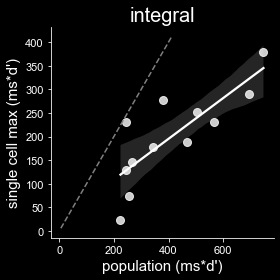

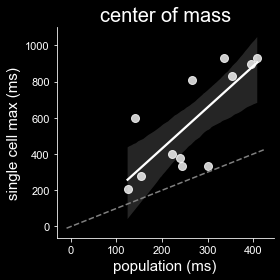

In [59]:
# integral
parameter = 'significant_abs_sum'
fig, ax = dPCA_SC_param_comparison(parameter, nan2zero=False, nozero=True, id_probe=False)
ax.legend(markerscale=1.5, loc='best')
file = f'SC DPCA {parameter} comparison'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()

# center of mass
parameter = 'significant_abs_mass_center'
fig, ax = dPCA_SC_param_comparison(parameter, nan2zero=False, nozero=True, id_probe=False)
ax.legend(markerscale=1.5, loc='best')
file = f'SC DPCA {parameter} comparison'
savefig(fig, 'WIP4_figures', file, type='png')
plt.show()